# Relation extraction with BERT

---

The goal of this notebook is to show how to use [BERT](https://arxiv.org/abs/1810.04805)
to [extract relation](https://en.wikipedia.org/wiki/Relationship_extraction) from text.

Used libraries:
- [PyTorch](https://pytorch.org/)
- [PyTorch-Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)
- [Transformers](https://huggingface.co/transformers/index.html)

Used datasets:
- SemEval 2010 Task 8 - [paper](https://arxiv.org/pdf/1911.10422.pdf) - [download](https://github.com/sahitya0000/Relation-Classification/blob/master/corpus/SemEval2010_task8_all_data.zip?raw=true)
- Google IISc Distant Supervision (GIDS) - [paper](https://arxiv.org/pdf/1804.06987.pdf) - [download](https://drive.google.com/open?id=1gTNAbv8My2QDmP-OHLFtJFlzPDoCG4aI)
- Riedel's New York Times - [paper](https://www.researchgate.net/publication/220698997_Modeling_Relations_and_Their_Mentions_without_Labeled_Text) - [download](https://drive.google.com/uc?id=1D7bZPvrSAbIPaFSG7ZswYQcPA3tmouCw&export=download)

## Install dependencies

This project uses [Python 3.7+](https://www.python.org/downloads/release/python-378/)

In [1]:
!pip install requests==2.23.0 numpy==1.18.5 pandas==1.0.3 \
    scikit-learn==0.23.1 pytorch-lightning==0.8.4 torch==1.5.1 \
    transformers==3.0.2 sklearn==0.0 tqdm==4.45.0 neptune-client==0.4.119 \
    matplotlib==3.1.0 scikit-plot==0.3.7

     |████████████████████████████████| 304 kB 191 kB/s eta 0:00:01
     |████████████████████████████████| 769 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 3.2 MB/s eta 0:00:011
     |████████████████████████████████| 13.1 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 138 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 3.6 MB/s  eta 0:00:01


  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=c84b0baec386fd66ec0cdc515f517000ce726bc23114561fd9920c096c497dce
  Stored in directory: /root/.cache/pip/wheels/64/3b/7e/69f84d99e2109788f757ef707b3ea51921f16891e42929eb31
  Created wheel for msgpack-python: filename=msgpack_python-0.5.6-cp37-cp37m-linux_x86_64.whl size=302580 sha256=86eac6891a62a0a89718214cd29f59ce1aca2efb1dd605fbcfd35ae6bd998399
  Stored in directory: /root/.cache/pip/wheels/f8/6c/02/92ebc97f3b99ad5bfc675be2c513f9cb3504fdbe338314f377
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18119 sha256=b9728743adb4f4a27af6ec701e261c2bbad3ab72eb3ddccfd5804d0405bc9bd5
  Stored in directory: /root/.cache/pip/wheels/f3/1d/9f/2a74caecb81b8beb9a4fbe1754203d4b7cf42ef5d39e0d2311
Successfully built neptune-client msgpack-python strict-rfc3339
ERROR: plotnine 0.7.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is i

## Import needed modules

In [3]:
import gc
import json
import math
import os
import shutil
import zipfile
from abc import ABC, abstractmethod
from scikitplot.metrics import plot_confusion_matrix
from typing import TextIO, Iterable, Tuple
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import pandas as pd
import requests
import torch
from pandas import DataFrame
from pytorch_lightning import LightningModule, seed_everything
from pytorch_lightning import Trainer as LightningTrainer
from pytorch_lightning.logging.neptune import NeptuneLogger
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import Tensor, nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import tqdm
from transformers import *

## Define constants

In [4]:
# --- Random seed ---
SEED = 2020
seed_everything(SEED)

# --- Neptune logger ---
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMTU3YTAxMjctYWQwOC00YTU4LTk5Y2ItM2JmNjJmNDJjY2VkIn0="
NEPTUNE_PROJECT_NAME="hung/bert-relation-extraction"

# --- Directory ---
ROOT_DIR = os.path.abspath('.')
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data/processed') 
METADATA_FILE_NAME = os.path.join(PROCESSED_DATA_DIR, 'metadata.json')
CHECKPOINT_DIR = os.path.join(ROOT_DIR, 'checkpoint')

# in local environment
RAW_DATA_DIR =  os.path.join(ROOT_DIR, 'data/raw')

# in Kaggle environment
# 3 datasets should already been added to the notebook
RAW_DATA_DIR = os.path.join(ROOT_DIR, '../input')

# --- Datasets ---
DATASET_MAPPING = {
    'SemEval2010Task8': {
        'dir': os.path.join(RAW_DATA_DIR,'semeval2010-task-8'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'SemEval2010_task8_all_data'),
        'url': 'https://github.com/sahitya0000/Relation-Classification/'
               'blob/master/corpus/SemEval2010_task8_all_data.zip?raw=true',
        'fit_in_memory': True
    },
    'GIDS': {
        'dir': os.path.join(RAW_DATA_DIR,'gids-dataset'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'gids_data'),
        'url': 'https://drive.google.com/uc?id=1gTNAbv8My2QDmP-OHLFtJFlzPDoCG4aI&export=download',
        'fit_in_memory': True
    },
    'NYT': {
        'dir': os.path.join(RAW_DATA_DIR,'nyt-relation-extraction'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'riedel_data'),
        'url': 'https://drive.google.com/uc?id=1D7bZPvrSAbIPaFSG7ZswYQcPA3tmouCw&export=download',
        'fit_in_memory': False
    }
}

# change this variable to switch dataset in later tasks
DATASET_NAME = 'SemEval2010Task8'

# --- BERT ---
SUB_START_CHAR = '['
SUB_END_CHAR = ']'
OBJ_START_CHAR = '{'
OBJ_END_CHAR = '}'

# --- BERT Model ---
# See https://huggingface.co/transformers/pretrained_models.html for the full list
AVAILABLE_PRETRAINED_MODELS = [
    'distilbert-base-uncased', 
    'distilbert-base-cased', 
    'distilgpt2', 
    'bert-base-uncased',
    'roberta-base'
]

# change this variable to switch pretrained language model in later tasks
PRETRAINED_MODEL = AVAILABLE_PRETRAINED_MODELS[0]

# if e1 is not related to e2, should "e2 not related to e1" be added to the trainning set
ADD_REVERSE_RELATIONSHIP = False

## Download data

This part **CAN BE SKIPPED** if this notebook is running on Kaggle environment since the dataset has already been included.

First, we install `gdown` to download files from Google Drive

In [ ]:
!pip install gdown==3.11.1
import gdown

Some download util functions:

In [ ]:
def download_from_url(url: str, save_path: str, chunk_size: int = 2048):
    with open(save_path, "wb") as f:
        print(f"Downloading...\nFrom: {url}\nTo: {save_path}")
        response = requests.get(url, stream=True)
        for data in tqdm(response.iter_content(chunk_size=chunk_size)):
            f.write(data)

def download_from_google_drive(url: str, save_path: str):
    gdown.download(url, save_path, use_cookies=False)

def extract_zip(zip_file_path: str, extract_dir: str, remove_zip_file: bool = True):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Extracting to " + extract_dir)
        for member in tqdm(zip_ref.infolist()):
            zip_ref.extract(member, extract_dir)

    if remove_zip_file:
        print("Removing zip file")
        os.unlink(zip_file_path)

The download function itself:

In [ ]:
def download(dataset_name: str, dataset_url: str, dataset_dir: str, dataset_extract_dir: str, force_redownload: bool):
    print(f"\n---> Downloading dataset {dataset_name} <---")
    
    # create raw data dir
    if not os.path.exists(RAW_DATA_DIR):
        print("Creating raw data directory " + RAW_DATA_DIR)
        os.makedirs(RAW_DATA_DIR)
    
    # check data has been downloaded
    if os.path.exists(dataset_dir):
        if force_redownload:
            print(f"Removing old raw data {dataset_dir}")
            shutil.rmtree(dataset_dir)
        else:
            print(f"Directory {dataset_dir} exists, skip downloading.")
            return


    # download
    tmp_file_path = os.path.join(RAW_DATA_DIR, dataset_name + '.zip')
    if urlparse(dataset_url).netloc == 'drive.google.com':
        download_from_google_drive(dataset_url, tmp_file_path)
    else:
        download_from_url(dataset_url, tmp_file_path)

    # unzip
    extract_zip(tmp_file_path, RAW_DATA_DIR)

    # rename
    os.rename(dataset_extract_dir, dataset_dir)

Download all datasets:

In [ ]:
def download_all_dataset():
    for dataset_name, dataset_info in DATASET_MAPPING.items():
        download(
            dataset_name,
            dataset_url=dataset_info['url'],
            dataset_dir=dataset_info['dir'],
            dataset_extract_dir=dataset_info['extract_dir'],
            force_redownload=False
        )

download_all_dataset()

## Preprocess

In [5]:
class AbstractPreprocessor(ABC):
    DATASET_NAME = ''
    VAL_DATA_PROPORTION = 0.2

    def __init__(self, tokenizer: PreTrainedTokenizer):
        self.tokenizer = tokenizer
        self.SUB_START_ID, self.SUB_END_ID, self.OBJ_START_ID, self.OBJ_END_ID \
            = tokenizer.convert_tokens_to_ids([SUB_START_CHAR, SUB_END_CHAR, OBJ_START_CHAR, OBJ_END_CHAR])

    def preprocess_data(self, reprocess: bool):
        print(f"\n---> Preprocessing {self.DATASET_NAME} dataset <---")
        
        # create processed data dir
        if not os.path.exists(PROCESSED_DATA_DIR):
            print("Creating processed data directory " + PROCESSED_DATA_DIR)
            os.makedirs(PROCESSED_DATA_DIR)

        # stop preprocessing if file existed
        json_file_names = [self.get_json_file_name(k) for k in ('train', 'val', 'test')]
        existed_files = [fn for fn in json_file_names if os.path.exists(fn)]
        if existed_files:
            file_text = "- " + "\n- ".join(existed_files)
            if not reprocess:
                print("The following files already exist:")
                print(file_text)
                print("Preprocessing is skipped. See option --reprocess.")
                return
            else:
                print("The following files will be overwritten:")
                print(file_text)

        self._preprocess_data()

    @abstractmethod
    def _preprocess_data(self):
        pass

    def _find_sub_obj_pos(self, input_ids_list: Iterable) -> DataFrame:
        sub_start_pos = [self._index(s, self.SUB_START_ID) + 1 for s in input_ids_list]
        sub_end_pos = [self._index(s, self.SUB_END_ID, sub_start_pos[i]) for i, s in enumerate(input_ids_list)]
        obj_start_pos = [self._index(s, self.OBJ_START_ID) + 1 for s in input_ids_list]
        obj_end_pos = [self._index(s, self.OBJ_END_ID, obj_start_pos[i]) for i, s in enumerate(input_ids_list)]
        return DataFrame({
            'sub_start_pos': sub_start_pos,
            'sub_end_pos': sub_end_pos,
            'obj_start_pos': obj_start_pos,
            'obj_end_pos': obj_end_pos,
        })

    def _index(self, lst: list, ele: int, start: int = 0) -> int:
        try:
            return lst.index(ele, start)
        except ValueError:
            return -1

    def _remove_invalid_sentences(self, data: DataFrame) -> DataFrame:
        seq_max_len = self.tokenizer.model_max_length
        return data.loc[
            (data['sub_end_pos'] < seq_max_len)
            & (data['obj_end_pos'] < seq_max_len)
            & (data['sub_end_pos'] > -1)
            & (data['obj_end_pos'] > -1)
        ]

    def _get_label_mapping(self, le: LabelEncoder):
        id_to_label = dict(enumerate(le.classes_))
        label_to_id = {v: k for k, v in id_to_label.items()}
        return {
            'id_to_label': id_to_label,
            'label_to_id': label_to_id
        }

    def _append_data_to_file(self, data: DataFrame, file: TextIO):
        lines = ""
        for _, row in data.iterrows():
            lines += row.to_json() + "\n"
        file.write(lines)

    def _save_metadata(self, metadata: dict):
        # create metadata file
        if not os.path.exists(METADATA_FILE_NAME):
            print(f"Create metadata file at {METADATA_FILE_NAME}")
            with open(METADATA_FILE_NAME, 'w') as f:
                f.write("{}\n")

        # add metadata
        print("Saving metadata")
        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
        with open(METADATA_FILE_NAME, 'w') as f:
            root_metadata[self.DATASET_NAME] = metadata
            json.dump(root_metadata, f, indent=4)

    @classmethod
    def get_json_file_name(cls, key: str) -> str:
        return os.path.join(PROCESSED_DATA_DIR, f'{cls.DATASET_NAME.lower()}_{key}.json')

class SemEval2010Task8Preprocessor(AbstractPreprocessor):
    DATASET_NAME = 'SemEval2010Task8'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'],
                                       'SemEval2010_task8_training/TRAIN_FILE.TXT')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'],
                                      'SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')
    RAW_TRAIN_DATA_SIZE = 8000
    RAW_TEST_DATA_SIZE = 2717

    def _preprocess_data(self):
        print("Processing training data")
        train_data = self._get_data_from_file(
            self.RAW_TRAIN_FILE_NAME,
            self.RAW_TRAIN_DATA_SIZE
        )

        print("Processing test data")
        test_data = self._get_data_from_file(
            self.RAW_TEST_FILE_NAME,
            self.RAW_TEST_DATA_SIZE
        )

        print("Encoding labels to integers")
        le = LabelEncoder()
        train_data['label'] = le.fit_transform(train_data['label'])
        test_data['label'] = le.transform(test_data['label'])

        print("Splitting train & validate data")
        train_data, val_data = train_test_split(train_data, shuffle=True, random_state=SEED)

        print("Saving to json files")
        with open(self.get_json_file_name('train'), 'w') as f:
            self._append_data_to_file(train_data, f)
        with open(self.get_json_file_name('val'), 'w') as f:
            self._append_data_to_file(val_data, f)
        with open(self.get_json_file_name('test'), 'w') as f:
            self._append_data_to_file(test_data, f)

        self._save_metadata({
            'train_size': len(train_data) ,
            'val_size': len(val_data),
            'test_size': len(test_data),
            **self._get_label_mapping(le)
        })

    def _get_data_from_file(self, file_name: str, dataset_size: int, reverse: bool = ADD_REVERSE_RELATIONSHIP) -> DataFrame:
        raw_sentences = []
        labels = []
        with open(file_name) as f:
            for _ in tqdm(range(dataset_size)):
                sent = f.readline()
                label, sub, obj = self._process_label(f.readline())
                labels.append(label)
                raw_sentences.append(self._process_sentence(sent, sub, obj))
                if label == 'Other' and reverse:
                    labels.append(label)
                    raw_sentences.append(self._process_sentence(sent, obj, sub))
                f.readline()
                f.readline()
        tokens = self.tokenizer(raw_sentences, truncation=True, padding='max_length')
        data = DataFrame(tokens.data)
        data['label'] = labels
        sub_obj_position = self._find_sub_obj_pos(data['input_ids'])
        data = pd.concat([data, sub_obj_position], axis=1)
        data = self._remove_invalid_sentences(data)
        return data

    def _process_sentence(self, sentence: str, sub: int, obj: int) -> str:
        return sentence.split("\t")[1][1:-2] \
            .replace(f"<e{sub}>", SUB_START_CHAR) \
            .replace(f"</e{sub}>", SUB_END_CHAR) \
            .replace(f"<e{obj}>", OBJ_START_CHAR) \
            .replace(f"</e{obj}>", OBJ_END_CHAR)

    def _process_label(self, label: str) -> Tuple[str, int, int]:
        label = label.strip()
        if label == 'Other':
            return label, 1, 2
        nums = list(filter(str.isdigit, label))
        return label, int(nums[0]), int(nums[1])

class LargeDatasetPreprocessor(AbstractPreprocessor):
    PROCESS_BATCH_SIZE = 2**12

    def _preprocess_data(self):
        pass

    def _process_batch(self, le: LabelEncoder, in_file: TextIO) -> DataFrame:
        raw_sentences = []
        labels = []

        for _ in range(self.PROCESS_BATCH_SIZE):
            dt = in_file.readline()
            if dt == "": break # EOF
            dt = json.loads(dt)

            # add subject markup
            sub = dt['sub']  # TODO keep _ or not?
            obj = dt['obj']
            new_sub = SUB_START_CHAR + ' ' + sub.replace("_", "") + ' ' + SUB_END_CHAR
            new_obj = OBJ_START_CHAR + ' ' +  obj.replace("_", "") + ' ' + OBJ_END_CHAR
            self._replace_once(dt['sent'], sub, new_sub)
            self._replace_once(dt['sent'], obj, new_obj)
            raw_sentences.append(" ".join(dt['sent']))
            labels.append(dt['rel'])

        if not raw_sentences:
            return DataFrame()

        tokens = self.tokenizer(raw_sentences, truncation=True, padding='max_length')
        data = DataFrame(tokens.data)
        data['label'] = le.fit_transform(labels)
        sub_obj_position = self._find_sub_obj_pos(data['input_ids'])
        data = pd.concat([data, sub_obj_position], axis=1)
        data = self._remove_invalid_sentences(data)
        return data

    def _replace_once(self, arr: list, element, replacement):
        for i, e in enumerate(arr):
            if e == element:
                arr[i] = replacement
                return
            if e[:-1] == element and e[-1] in ',.?!;:':
                arr[i] = replacement + e[-1]
                return

    def _process_subset(self, le: LabelEncoder, in_file_name, out_file_name, data_size) -> int:
        total_data_size = 0
        with open(in_file_name) as in_file, open(out_file_name, 'w') as out_file:
            batch_count = math.ceil(data_size / self.PROCESS_BATCH_SIZE)
            for _ in tqdm(range(batch_count)):
                data = self._process_batch(le, in_file)
                self._append_data_to_file(data, out_file)
                total_data_size += len(data)
        return total_data_size

class GIDSPreprocessor(LargeDatasetPreprocessor):
    DATASET_NAME = 'GIDS'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_train.json')
    RAW_VAL_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_dev.json')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_test.json')
    TRAIN_SIZE = 11297
    VAL_SIZE = 1864
    TEST_SIZE = 5663
    PROCESS_BATCH_SIZE = 1024

    def _preprocess_data(self):
        le = LabelEncoder()
        
        print("Process train dataset")
        actual_train_size = self._process_subset(
            le,
            self.RAW_TRAIN_FILE_NAME,
            self.get_json_file_name('train'),
            self.TRAIN_SIZE
        )

        print("Process val dataset")
        actual_val_size = self._process_subset(
            le,
            self.RAW_VAL_FILE_NAME,
            self.get_json_file_name('val'),
            self.VAL_SIZE
        )
        
        print("Process test dataset")
        actual_test_size = self._process_subset(
            le, 
            self.RAW_TEST_FILE_NAME, 
            self.get_json_file_name('test'),
            self.TEST_SIZE
        )

        self._save_metadata({
            'train_size': actual_train_size,
            'val_size': actual_val_size,
            'test_size': actual_test_size,
            **self._get_label_mapping(le)
        })

class NYTPreprocessor(LargeDatasetPreprocessor):
    DATASET_NAME = 'NYT'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['NYT']['dir'], 'riedel_train.json')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['NYT']['dir'], 'riedel_test.json')
    TRAIN_SIZE = 570084
    TEST_SIZE = 172448
    PROCESS_BATCH_SIZE = 4096 * 4

    def _preprocess_data(self):
        le = LabelEncoder()
        actual_train_size = 0
        actual_val_size = 0

        print("Process train & val dataset")
        batch_count = math.ceil(self.TRAIN_SIZE / self.PROCESS_BATCH_SIZE)
        with open(self.RAW_TRAIN_FILE_NAME) as in_file,\
                open(self.get_json_file_name('train'), 'w') as train_file,\
                open(self.get_json_file_name('val'), 'w') as val_file:
                    for _ in tqdm(range(batch_count)):
                        data = self._process_batch(le, in_file)
                        train_data, val_data = train_test_split(data, shuffle=True, random_state=SEED)
                        self._append_data_to_file(train_data, train_file)
                        self._append_data_to_file(val_data, val_file)
                        actual_train_size += len(train_data)
                        actual_val_size += len(val_data)

        print("Process test dataset")
        actual_test_size = self._process_subset(
            le, 
            self.RAW_TEST_FILE_NAME, 
            self.get_json_file_name('test'),
            self.TEST_SIZE
        )

        self._save_metadata({
            'train_size': actual_train_size,
            'val_size': actual_val_size,
            'test_size': actual_test_size,
            **self._get_label_mapping(le)
        })
        

def get_preprocessor_class():
    return globals()[f'{DATASET_NAME}Preprocessor']
        
def get_preprocessor()-> AbstractPreprocessor:
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
    preprocessors_class = get_preprocessor_class()
    return preprocessors_class(tokenizer)



In [6]:
preprocessor = get_preprocessor()
preprocessor.preprocess_data(reprocess=True)



---> Preprocessing SemEval2010Task8 dataset <---
Creating processed data directory /kaggle/working/data/processed
Processing training data



Processing test data



Encoding labels to integers
Splitting train & validate data
Saving to json files
Create metadata file at /kaggle/working/data/processed/metadata.json
Saving metadata


## Model

### Dataset

In [8]:
class GenericDataset(IterableDataset):

    def __init__(self, subset: str, batch_size: int):
        assert subset in ['train', 'val', 'test']
            
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)
        self.length = math.ceil(metadata[DATASET_NAME][f'{subset}_size'] / batch_size)
        
        preprocessor_class = get_preprocessor_class()
        self.file = open(preprocessor_class.get_json_file_name(subset))

        self.fit_in_memory = DATASET_MAPPING[DATASET_NAME]['fit_in_memory']

    def __del__(self):
        self.file.close()

    def __iter__(self):
        if self.fit_in_memory:
            lines = self.file.readlines()
        else:
            lines = self.file

        def get_data():
            for line in lines:
                data = json.loads(line)
                input_data = {k: torch.tensor(v) for k, v in data.items() if k != 'label'}
                yield input_data, data['label']

        return get_data()
    
    def __len__(self):
        return self.length

### Torch Lightning Module

In [9]:
def decay_lr(epoch):
    return [1, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01][epoch]

def get_activation_layer(activate_func_name):
    return getattr(nn, activate_func_name)()

class BERTModule(LightningModule):

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate,
                 bert_cls_size, bert_entity_size, dropout_p, activation_function, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        self.proposed_answer = None

        self.obj_stream = torch.cuda.Stream()
        self.sub_stream = torch.cuda.Stream()
        
        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        
        self.cls_dropout = nn.Dropout(p=self.hparams.dropout_p)
        self.cls_linear = nn.Linear(self.language_model.config.hidden_size, bert_cls_size)
        self.cls_activate = get_activation_layer(activation_function)
        
        self.sub_dropout = nn.Dropout(p=self.hparams.dropout_p)
        self.sub_linear = nn.Linear(self.language_model.config.hidden_size, bert_entity_size)
        self.sub_activate = get_activation_layer(activation_function)
        
        self.obj_dropout = nn.Dropout(p=self.hparams.dropout_p)
        self.obj_linear = nn.Linear(self.language_model.config.hidden_size, bert_entity_size)
        self.obj_activate = get_activation_layer(activation_function)
        
        with open(METADATA_FILE_NAME) as f:
            num_classes = len(json.load(f)[dataset_name]['id_to_label'])
        self.linear = nn.Linear(bert_cls_size + 2 * bert_entity_size, num_classes)
        self.lin_dropout = nn.Dropout(p=self.hparams.dropout_p)

    def train_dataloader(self) -> DataLoader:
        return self.__get_dataloader('train')

    def val_dataloader(self) -> DataLoader:
        return self.__get_dataloader('val')

    def test_dataloader(self) -> DataLoader:
        return self.__get_dataloader('test')

    def __get_dataloader(self, subset: str) -> DataLoader:
        batch_size = self.hparams.batch_size
        return DataLoader(
            GenericDataset(subset, batch_size),
            batch_size=batch_size,
            #shuffle=(subset == 'train'),
            num_workers=1
        )

    def configure_optimizers(self):
        optimizer = AdamW(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = LambdaLR(optimizer, decay_lr)
        return [optimizer], [scheduler]

    def forward(self, input_ids, attention_mask, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos) -> Tensor:
        language_model_output, = self.language_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        torch.cuda.synchronize()
        bz = language_model_output.shape[0]
            
        with torch.cuda.stream(self.sub_stream):
            bert_sub = [torch.mean(language_model_output[i, sub_start_pos[i]:sub_end_pos[i]], dim=0) for i in range(bz)]
            bert_sub = self.sub_dropout(torch.stack(bert_sub))
            sub_output = self.sub_activate(self.sub_linear(bert_sub))
            
        with torch.cuda.stream(self.obj_stream):
            bert_obj = [torch.mean(language_model_output[i, obj_start_pos[i]:obj_end_pos[i]], dim=0) for i in range(bz)]
            bert_obj = self.obj_dropout(torch.stack(bert_obj))
            obj_output = self.obj_activate(self.obj_linear(bert_obj))
            
        bert_cls = self.cls_dropout(language_model_output[:, 0])
        cls_output = self.cls_activate(self.cls_linear(bert_cls))

        torch.cuda.synchronize()

        linear_input = self.lin_dropout(torch.cat((cls_output, sub_output, obj_output), dim=1))
#         linear_input = self.lin_dropout(torch.mean(bert_output, dim=1))
        logits = self.linear(linear_input)

        return logits

    def training_step(self, batch, batch_nb) -> dict:
        input_data, label = batch
        y_hat = self(**input_data)

        loss = F.cross_entropy(y_hat, label)
        tensorboard_logs = {'train_loss': loss}

        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb) -> dict:
        input_data, label = batch
        y_hat = self(**input_data)

        loss = F.cross_entropy(y_hat, label)

        y_hat = torch.argmax(y_hat, dim=1)

        return {
            'y_hat': y_hat,
            'label': label,
            'val_loss': loss,
        }

    def validation_epoch_end(self, outputs) -> dict:
        losses = torch.stack([x['val_loss'] for x in outputs])
        avg_val_loss = losses.mean()

        y_hat = torch.cat([x['y_hat'] for x in outputs]).cpu()
        label = torch.cat([x['label'] for x in outputs]).cpu()
        fig, ax = plt.subplots(figsize=(16, 12))
        plot_confusion_matrix(label, y_hat, ax=ax)
        self.logger.experiment.log_image('val_confusion_matrix', fig)

        logs = {
            'avg_val_loss': avg_val_loss,
            'val_acc': torch.tensor(accuracy_score(label, y_hat)),
            'val_pre_micro': torch.tensor(precision_score(label, y_hat, average='micro')),
            'val_rec_micro': torch.tensor(recall_score(label, y_hat, average='micro')),
            'val_f1_micro': torch.tensor(f1_score(label, y_hat, average='micro')),
            'val_pre_macro': torch.tensor(precision_score(label, y_hat, average='macro')),
            'val_rec_macro': torch.tensor(recall_score(label, y_hat, average='macro')),
            'val_f1_macro': torch.tensor(f1_score(label, y_hat, average='macro')),
        }

        for k, v in logs.items():
            self.logger.experiment.log_metric(k, v)

        return {'val_loss': avg_val_loss, 'progress_bar': logs}

    def test_step(self, batch, batch_nb) -> dict:
        input_data, label = batch
        y_hat = self(**input_data)

        y_hat = torch.argmax(y_hat, dim=1)

        return {
            'y_hat': y_hat,
            'label': label,
        }


    def test_epoch_end(self, outputs) -> dict:
        y_hat = torch.cat([x['y_hat'] for x in outputs]).cpu()
        label = torch.cat([x['label'] for x in outputs]).cpu()

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_confusion_matrix(label, y_hat, ax=ax)
        self.logger.experiment.log_image(f'test_confusion_matrix', fig)

        logs = {
            'test_acc': torch.tensor(accuracy_score(label, y_hat)),
            'test_pre_micro': torch.tensor(precision_score(label, y_hat, average='micro')),
            'test_rec_micro': torch.tensor(recall_score(label, y_hat, average='micro')),
            'test_f1_micro': torch.tensor(f1_score(label, y_hat, average='micro')),
            'test_pre_macro': torch.tensor(precision_score(label, y_hat, average='macro')),
            'test_rec_macro': torch.tensor(recall_score(label, y_hat, average='macro')),
            'test_f1_macro': torch.tensor(f1_score(label, y_hat, average='macro')),
        }

        for k, v in logs.items():
            self.logger.experiment.log_metric(k, v)

        self.proposed_answer = y_hat.cpu().tolist()

        return {'progress_bar': logs}

## Claiming back memory & diskspace

See [this](https://stackoverflow.com/a/61707643/7342188) and [this](https://stackoverflow.com/a/57860310/7342188)

In [ ]:
1 / 0

In [18]:
model = None
trainer = None
gc.collect()
torch.cuda.empty_cache()

In [19]:

logger = None

In [ ]:
try:
    shutil.rmtree(CHECKPOINT_DIR)
except:
    pass

## Logger

In [20]:
logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

https://ui.neptune.ai/hung/bert-relation-extraction/e/BERT-47


NeptuneLogger will work in online mode


## Trainer

In [22]:
GPUS = 1
MIN_EPOCHS = 1
MAX_EPOCHS = 6


trainer = LightningTrainer(
    gpus=GPUS,
    min_epochs=MIN_EPOCHS,
    max_epochs=MAX_EPOCHS,
#     auto_lr_find='learning_rate',
    default_root_dir=CHECKPOINT_DIR,
    reload_dataloaders_every_epoch=True, # needed as we loop over a file,
    deterministic=True,
    logger=logger
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


## Training

Create a model object:

In [12]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-05

BERT_CLS_SIZE = 64
BERT_ENTITY_SIZE = 32

DROPOUT_P = 0.0
ACTIVATION_FUNCTION = "PReLU"
WEIGHT_DECAY = 0.2 # default = 0.01

model = BERTModule(
    pretrained_language_model=PRETRAINED_MODEL,
    dataset_name=DATASET_NAME,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    bert_cls_size=BERT_CLS_SIZE,
    bert_entity_size=BERT_ENTITY_SIZE,
    dropout_p=DROPOUT_P,
    activation_function=ACTIVATION_FUNCTION,
    weight_decay=WEIGHT_DECAY
)

Start training:


   | Name           | Type            | Params
----------------------------------------------------
0  | language_model | DistilBertModel | 66 M  
1  | cls_dropout    | Dropout         | 0     
2  | cls_linear     | Linear          | 49 K  
3  | cls_activate   | PReLU           | 1     
4  | sub_dropout    | Dropout         | 0     
5  | sub_linear     | Linear          | 24 K  
6  | sub_activate   | PReLU           | 1     
7  | obj_dropout    | Dropout         | 0     
8  | obj_linear     | Linear          | 24 K  
9  | obj_activate   | PReLU           | 1     
10 | linear         | Linear          | 2 K   
11 | lin_dropout    | Dropout         | 0     
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-processing data loading (e.g. batch size > 1), this can lead to unintended side effects since the samples will be duplicated.
  warnings.warn(*args, **kwargs)
/opt/

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

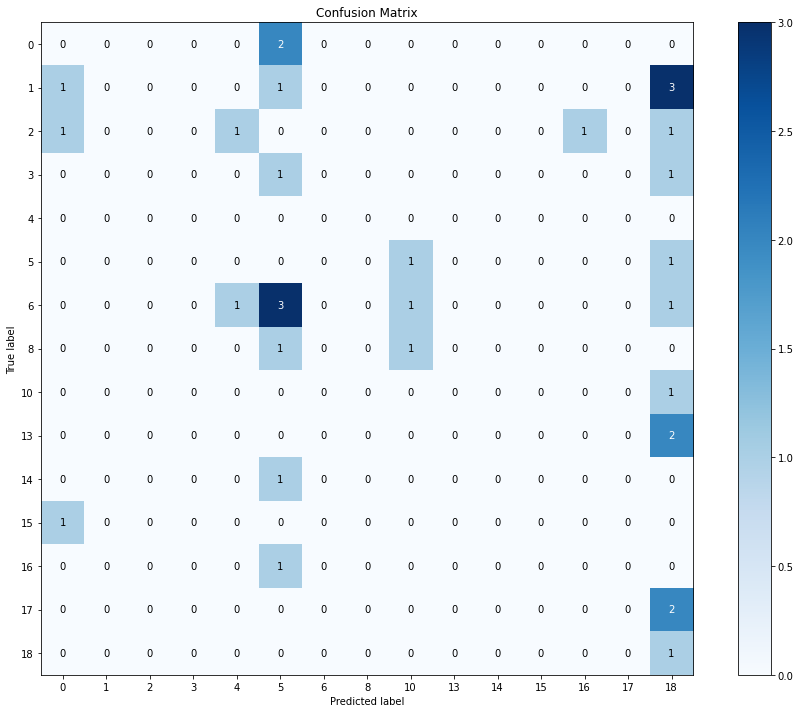

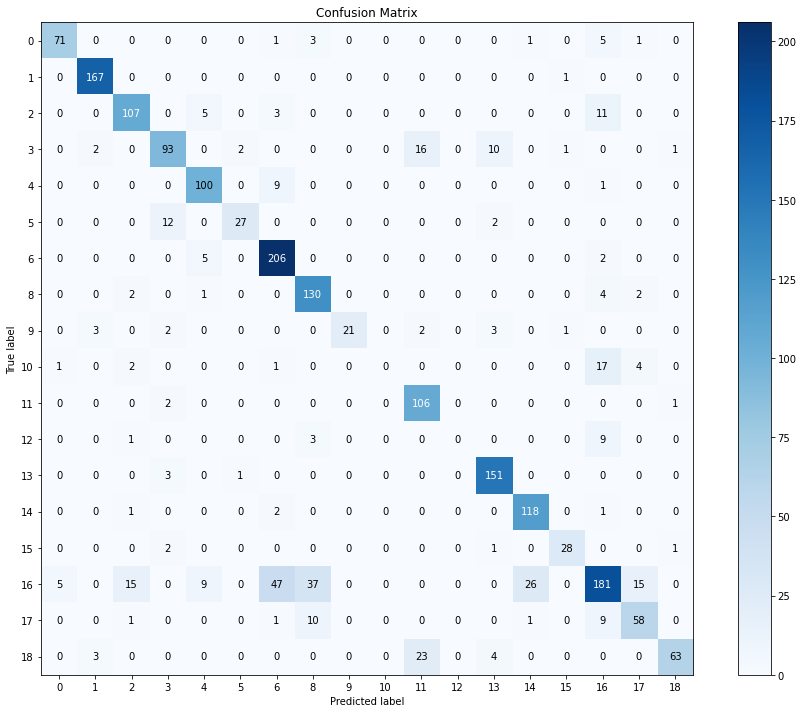

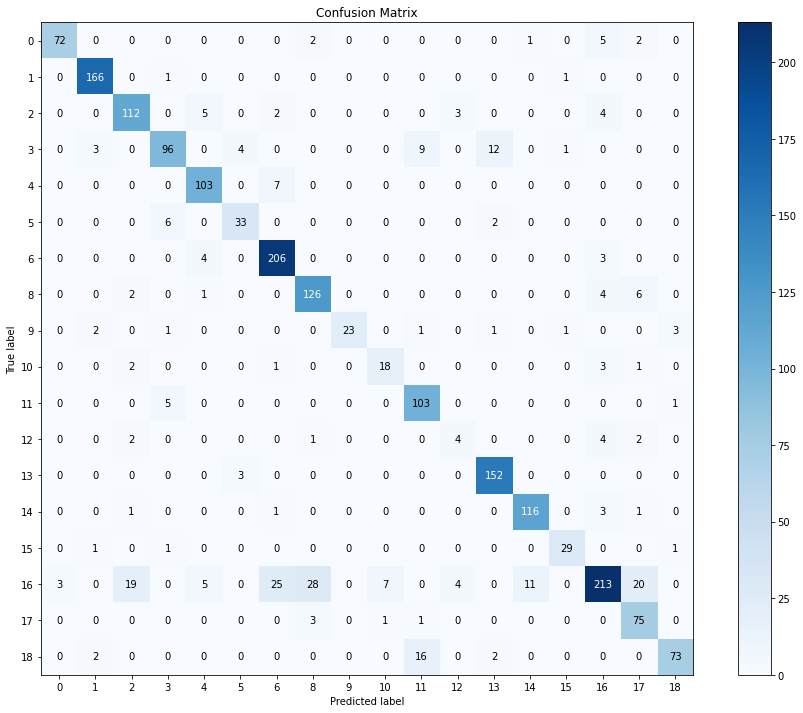

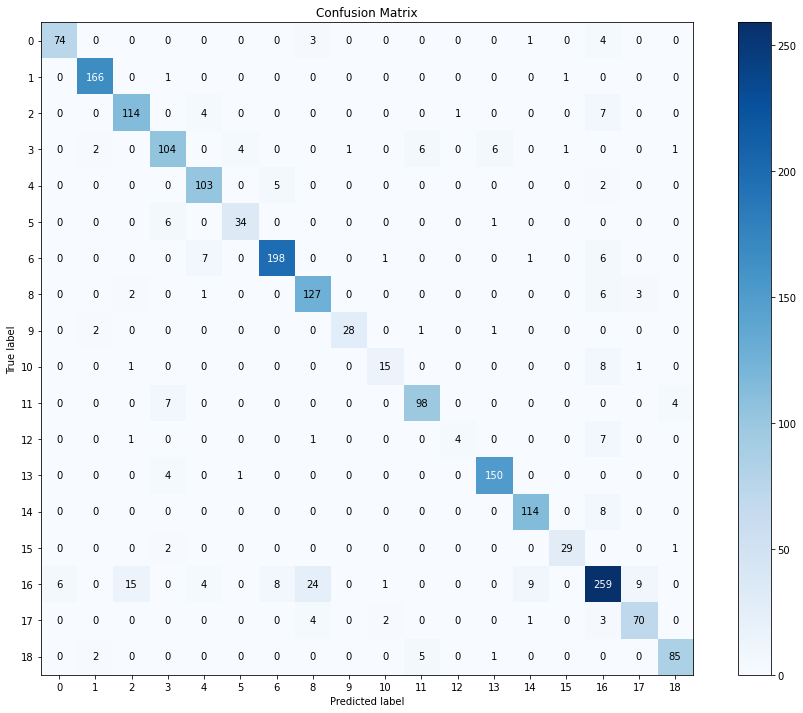

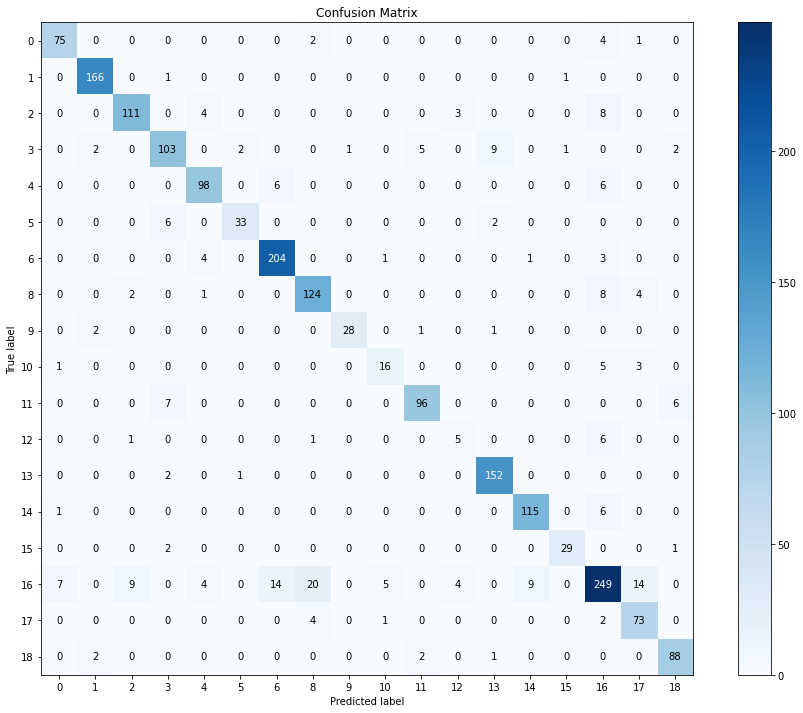

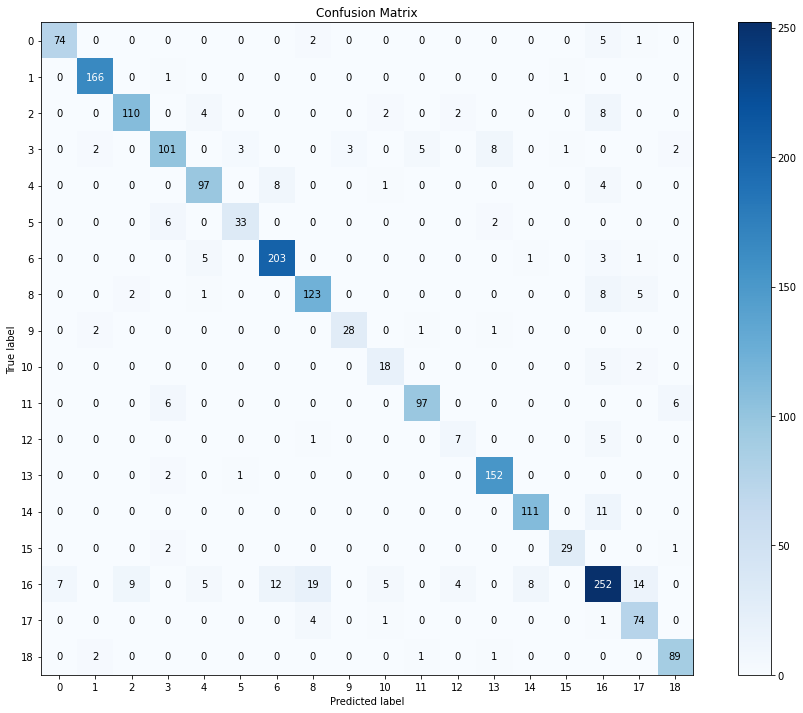

In [13]:
trainer.fit(model)

## Testing

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 2 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': tensor(0.8900, dtype=torch.float64),
 'test_f1_macro': tensor(0.8367, dtype=torch.float64),
 'test_f1_micro': tensor(0.8900, dtype=torch.float64),
 'test_pre_macro': tensor(0.8348, dtype=torch.float64),
 'test_pre_micro': tensor(0.8900, dtype=torch.float64),
 'test_rec_macro': tensor(0.8410, dtype=torch.float64),
 'test_rec_micro': tensor(0.8900, dtype=torch.float64)}
--------------------------------------------------------------------------------



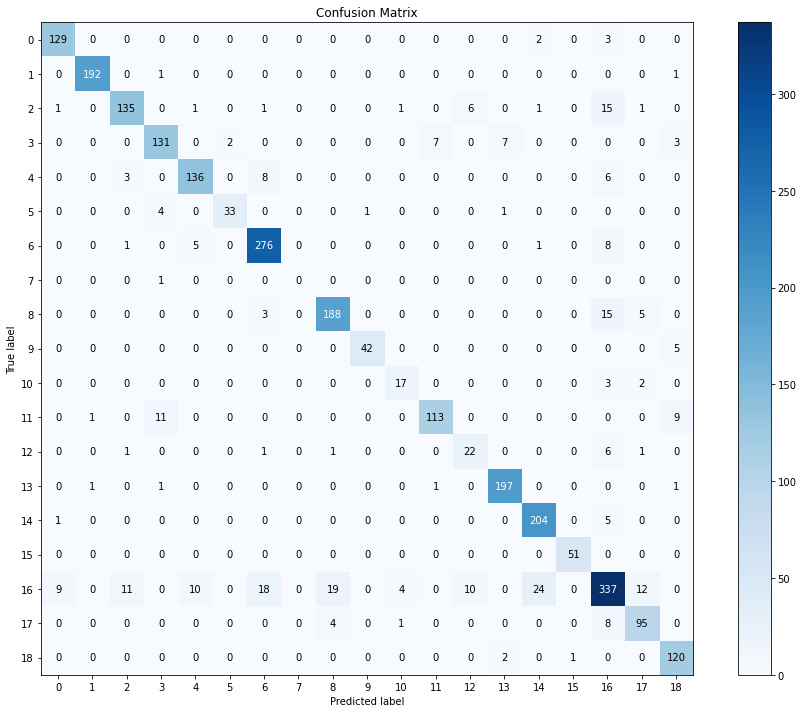

In [14]:
trainer.test(model)

## Run the offical scorer

Some datasets comes with offical scorers. We will run them in this session.

In [15]:
class AbstractScorer(ABC):
    @abstractmethod
    def score(self, proposed_answer):
        pass

class SemEval2010Task8Scorer(AbstractScorer):
    RESULT_FILE = "semeval2010_task8_offical_score.txt"
    PROPOSED_ANSWER_FILE = "semeval2010_task8_proposed_answer.txt"
    SCORER = "../input/semeval2010-task-8/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl"
    FORMAT_CHECKER = "../input/semeval2010-task-8/SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl"
    ANSWER_KEY = "../input/semeval2010-task-8/SemEval2010_task8_testing_keys/TEST_FILE_KEY.TXT"

    def score(self, proposed_answer):

        # write test_result to file
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)
            id_to_label = {int(k): v for k, v in metadata[DATASET_NAME]['id_to_label'].items()}
        i = 8001
        with open(self.PROPOSED_ANSWER_FILE, "w") as f:
            for r in proposed_answer:
                f.write(f"{i}\t{id_to_label[r]}\n")
                i += 1

        # call the official scorer
        os.system(f"perl {self.FORMAT_CHECKER} {self.PROPOSED_ANSWER_FILE}")
        os.system(f"perl {self.SCORER} {self.PROPOSED_ANSWER_FILE} {self.ANSWER_KEY} > {self.RESULT_FILE}")

        # log the official score
        with open(self.RESULT_FILE) as f:
            result = f.read()
            print(result)
        logger.experiment.log_artifact(self.RESULT_FILE)

def get_offical_scorer(dataset_name: str) -> AbstractScorer:
    return globals()[dataset_name + "Scorer"]()

In [16]:
scorer = get_offical_scorer(DATASET_NAME)
scorer.score(model.proposed_answer)

<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 129    0    0    0    0    0    0    0    0    0    0    0    0    0    2    0    0    0    3 |  134    0  134
 C-E2 |   0  192    0    1    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0 |  194    0  194
 C-W1 |   1    0  135    0    1    0    1    0    0    0    1    0    6    0    1    0    1    0   15 |  162    0  162
 C-W2 |   0    0    0  131    0    2    0    0    0    0    0    7    0    7    0    0    0    3    0 |  150    0  150
 C-C1 |   0    0    3    0  136    0    8    0    0    0    0    0    0    0    0    0    0    0    6 |  153    0  153
 C-C2 |   0    0    0    4    0   33    0    0    0    1    0    0    0    1    0    0   

## Clean up



In [17]:
logger.experiment.stop()